### Setup

In [23]:
# Import packages needed
import numpy as np
import pandas as pd
import pickle
import os
os.environ["H5PY_DEFAULT_READONLY"] = "1" # Surpress h5py deprecation warnings
import socket
from datetime import datetime
from seticore import viewer # If you don't have it, use pip install "git+https://github.com/MydonSolutions/seticore#egg=seticore&subdirectory=python"
import matplotlib.pyplot as plt
import setigen as stg
from astropy import units as u

%matplotlib inline
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# Load in data
data_dir = "/mnt/cosmic-gpu-1/data0/nstiegle/"
filename = "25GHz_higher_coherent.csv"
data_file = data_dir + filename
df = pd.read_csv(data_file)
print(df.shape)

(2984740, 17)


In [14]:
# Look for the stamp in a single stamp file
# Assumes the stamp_uri exists 
def find_stamp_in_single_file(stamp_uri, hit_frequency, threshold):
    # Check each stamp in the file to see if it matches
    stamps_gen = viewer.read_stamps(stamp_uri, find_recipe=True)
    for i, stamp in enumerate(stamps_gen):
        assert(stamp != None)
        assert(stamp.recipe != None)
        if abs(stamp.stamp.signal.frequency - hit_frequency) < threshold*1e-6:
            # Found the stamp!
            return i, stamp
    
    # Didn't find the stamp in this whole file of stamps
    return None, None

# Given a stamp_uri, increments the index of the stamp file by one (so if it's /.../...seticore.0000.stamps it goes to /.../...seticore.0001.stamps)
def increment_stamp_uri(stamp_uri):
    split_uri = stamp_uri.split('.')
    assert(split_uri[-1] == 'stamps')
    num = int(split_uri[-2])
    num += 1
    split_uri[-2] = str(num).zfill(4)
    return ".".join(split_uri)

# Finds where the stamp of a given hit is
# Takes:
# - stamp URI (of stamp file)
# - the frequency the hit occurred at
# - The width of the stamp file (distance in Hz from center of stamp file to hit_frequency to call hit in stamp file)
# Returns stamp_uri, index_in_stamp_file if found, otherwise None, None
def find_stamp_location_helper(stamp_uri, hit_frequency, threshold):
    # Check stamp file passed in exists
    if not os.path.exists(stamp_uri):
        return None, None
    
    # Look for stamp in the stamp file given
    index, stamp = find_stamp_in_single_file(stamp_uri, hit_frequency, threshold)
    if (index != None) and (stamp != None):
        return stamp_uri, index
    else:
        # Check if there's another stamp file (because stamps can get split up into multiple files)
        return find_stamp_location_helper(increment_stamp_uri(stamp_uri), hit_frequency, threshold)

# Finds where the stamp of a given hit is
# Takes:
# - hit URI (of .hits file)
# - the frequency the hit occurred at
# - The width of the stamp file (distance in Hz from center of stamp file to hit_frequency to call hit in stamp file)
# Returns stamp_uri, index_in_stamp_file if found, otherwise None, None
def find_stamp_location(hit_uri, hit_frequency, threshold=500):
    # Convert a filepath from pointing to a .hits
    # to a .stamps file for the same uri
    # If given a .stamps ending, doesn't change it
    def stamp_filepath_of(hits_filepath):
        return hits_filepath.replace('.hits', '.0000.stamps')

    return find_stamp_location_helper(stamp_filepath_of(hit_uri), hit_frequency, threshold)

### Code to look at stamp of id

In [20]:
def find_stamp_from_id(stamp_id):
    # Find the stamp we want
    row = df[df.id == stamp_id]
    stamp_uri, index_in_stamp = find_stamp_location(row.file_uri.values[0], row.signal_frequency.values[0])
    print(stamp_uri)
    print("Index in stamp:", index_in_stamp)
    stamps = [stamp for stamp in viewer.read_stamps(stamp_uri, find_recipe=True)]
    stamp = stamps[index_in_stamp]
    assert(stamp != None)
    assert(stamp.recipe != None)
    return stamp

### Code to look at dedrifting a stamp

In [21]:
def investigate_stamp(stamp):
    snr_thresh = 8 # Threshold for SNR used when finding hits in seticore
    
    ### Look at the coherent first if this is coherent
    beam = stamp.stamp.signal.beam
    if beam >= 0:
        # Look at raw stamp
        print("Coherent Results:")
        try:
            stamp.show_best_beam(show_signal=True, title=f"Coherent Beam - " +
                                                         f"Time: {datetime.fromtimestamp(int(stamp.stamp.tstart))}, " +  
                                                         f"SNR: {round(stamp.stamp.signal.snr, 3)}, " + 
                                                         f"DR: {round(stamp.stamp.signal.driftRate, 3)}Hz/s")
        except IndexError:
            beam = 0
            stamp.show_beam(beam, show_signal=True, title=f"Coherent Beam - " + 
                                                          f"Time: {datetime.fromtimestamp(int(stamp.stamp.tstart))}, " +  
                                                          f"SNR: {round(stamp.stamp.signal.snr, 3)}, " + 
                                                          f"DR: {round(stamp.stamp.signal.driftRate, 3)}Hz/s")

    # Look at dedrifted stamp
    powers = stamp.beamform_power(beam)
    frame = stg.Frame.from_data(stamp.stamp.foff * u.MHz, stamp.stamp.tsamp * u.s, stamp.stamp.fch1 * u.MHz, True, powers)
    dedrifted = stg.dedrift(frame, stamp.stamp.signal.driftRate)
    fig = plt.figure(figsize=(15, 1.5))
    stg.plot(dedrifted)
    plt.title(f"Dedrifted Coherent Beam - " + 
              f"Time: {datetime.fromtimestamp(int(stamp.stamp.tstart))}, " +  
              f"SNR: {round(stamp.stamp.signal.snr, 3)}, " + 
              f"DR: {round(stamp.stamp.signal.driftRate, 3)}Hz/s")
    plt.show()

    # Look at integrating columns of dedrifted stamp
    integrated = stg.integrate(dedrifted, mode='sum')
    fig = plt.figure(figsize=(15, 1.5))
    plt.xlabel("Frequency Bins (px)")
    plt.ylabel("Integrated Intensity After Dedrifting")
    plt.title(f"Dedrifted and Integrated Coherent Beam - " + 
              f"Time: {datetime.fromtimestamp(int(stamp.stamp.tstart))}, " +  
              f"SNR: {round(stamp.stamp.signal.snr, 3)}, " + 
              f"DR: {round(stamp.stamp.signal.driftRate, 3)}Hz/s")
    plt.plot(integrated)

    ## Look at how SNR was calculated for this hit
    # Compute Statistics
    median = np.percentile(integrated, 50)
    top_5 = np.percentile(integrated, 95)
    bottom_5 = np.percentile(integrated, 5)
    center_data = integrated[(integrated < top_5) * (integrated > bottom_5)]
    std_dev = center_data.std()
    print("Local SNR of this stamp calculated using seticore method:", (max(integrated) - median) / std_dev)
    
    # Show snr histogram
    fig = plt.figure(figsize=(15, 1.5))
    plt.hist(integrated, bins=100)
    plt.axvline(top_5, dashes=[1, 1, 1, 1], color='red', label="Top 5%")
    plt.axvline(bottom_5, dashes=[1, 1, 1, 1], color='red', label="Botom 5%")
    plt.axvline(median, color='orange', label='median')
    plt.axvline(median + std_dev, color='yellow', dashes=[1, 1, 1, 1], label='+1std')
    plt.axvline(median - std_dev, color='yellow', dashes=[1, 1, 1, 1], label='-1std')
    plt.axvline(median + snr_thresh * std_dev, color='grey', dashes=[1, 1, 1, 1], label=f'+{snr_thresh}std')
    plt.axvline(max(integrated), color='purple', label='signal')
    plt.legend(loc='upper left')
    plt.title(f"Histogram of Dedrifted and Integrated Coherent Beam - " + 
            f"Time: {datetime.fromtimestamp(int(stamp.stamp.tstart))}, " +  
            f"SNR: {round(stamp.stamp.signal.snr, 3)}, " + 
            f"DR: {round(stamp.stamp.signal.driftRate, 3)}Hz/s")    
    plt.xlabel("Integrated Column Intensity After Dedrifting")
    plt.ylabel("Count")
    plt.show()

    # Look at power over frequency but in snr unis
    fig = plt.figure(figsize=(15, 1.5))
    plt.plot((integrated - median) / std_dev)
    plt.axhline(snr_thresh, dashes=[1, 1, 1, 1], color='red', label=f"SNR = {snr_thresh}")
    plt.axhline(0, dashes=[1, 1, 1, 1], color='green', label="Calculated Noise Floor")
    plt.axhline(1, dashes=[1, 1, 1, 1], color='grey', label="+1std")
    plt.axhline(-1, dashes=[1, 1, 1, 1], color='grey', label="-1std")
    plt.ylabel("Standard Deviations above Noise Floor")
    plt.xlabel("Frequency Bin (px)")
    plt.legend()
    plt.title(f"Noise Calculation of Hit from Histogram Coherent Beam - " + 
            f"Time: {datetime.fromtimestamp(int(stamp.stamp.tstart))}, " +  
            f"SNR: {round(stamp.stamp.signal.snr, 3)}, " + 
            f"DR: {round(stamp.stamp.signal.driftRate, 3)}Hz/s")
    plt.show()

    ## Look at how the signal changes with drift rate
    # Get snr of hit detected
    def give_snr_of_max(integrated):
        median = np.percentile(integrated, 50)
        top_5 = np.percentile(integrated, 95)
        bottom_5 = np.percentile(integrated, 5)
        center_data = integrated[(integrated < top_5) * (integrated > bottom_5)]
        std_dev = center_data.std()
        return (max(integrated) - median) / std_dev
    
    # Try stamp with variety of drift rates
    maxes = []
    medians = []
    snr_of_maxes = []
    drift_rates_to_try = np.arange(-50, 50, .125)
    for i, dr in enumerate(drift_rates_to_try):
        test_dedrifted = stg.dedrift(frame, dr)
        test_integrated = stg.integrate(test_dedrifted, mode='sum')
        peak = max(test_integrated)
        maxes.append(peak)
        median = np.median(test_integrated)
        medians.append(median)
        snr_of_max = give_snr_of_max(test_integrated)
        snr_of_maxes.append(snr_of_max)

    # Plot stamp with variety of drift rates
    plt.plot(drift_rates_to_try, snr_of_maxes)
    plt.scatter(stamp.stamp.signal.driftRate, give_snr_of_max(integrated), marker='o', color='red', label="Actual Drift Rate", zorder=100)
    plt.title(f"How Coherent Beam Hit Changes with Searched Drift Rate- " + 
              f"Time: {datetime.fromtimestamp(int(stamp.stamp.tstart))}, " +  
              f"SNR: {round(stamp.stamp.signal.snr, 3)}, " + 
              f"DR: {round(stamp.stamp.signal.driftRate, 3)}Hz/s")
    plt.xlabel("Drift Rate Dedrifted (Hz/s)")
    plt.ylabel("SNR of Max Intensity")
    plt.legend()
    plt.show()

    # Look at what went into that plot
    plt.plot(drift_rates_to_try, maxes, label='Max')
    plt.plot(drift_rates_to_try, medians, label="Median")
    plt.title(f"How Coherent Beam Hit Changes with Searched Drift Rate- " + 
              f"Time: {datetime.fromtimestamp(int(stamp.stamp.tstart))}, " +  
              f"SNR: {round(stamp.stamp.signal.snr, 3)}, " + 
              f"DR: {round(stamp.stamp.signal.driftRate, 3)}Hz/s")
    plt.xlabel("Drift Rate Dedrifted (Hz/s)")
    plt.ylabel("Intensity in Single Bin\nafter Dedrifting and Integrating")
    plt.legend(loc='lower center')
    plt.show()

    ### Look at incoherent beam
    # Look at same with incoherent
    incoherent = np.square(stamp.real_array()).sum(axis=(2, 3, 4))
    incoherent_frame = stg.Frame.from_data(stamp.stamp.foff * u.MHz, stamp.stamp.tsamp * u.s, stamp.stamp.fch1 * u.MHz, True, incoherent)
    incoherent_dedrifted = stg.dedrift(incoherent_frame, stamp.stamp.signal.driftRate)
    incoherent_integrated = stg.integrate(incoherent_dedrifted, mode='sum')
    fig = plt.figure(figsize=(15, 1.5))
    plt.plot(incoherent_integrated)
    plt.xlabel("Frequency Bins (px)")
    plt.ylabel("Integrated Intensity After Dedrifting")
    plt.title(f"Dedrifted and Integrated Incoherent Beam - " + 
              f"Time: {datetime.fromtimestamp(int(stamp.stamp.tstart))}, " +  
              f"SNR: {round(stamp.stamp.signal.snr, 3)}, " + 
              f"DR: {round(stamp.stamp.signal.driftRate, 3)}Hz/s")
    plt.show()

### LOok at stamps

In [16]:
stamp_ids = [961506092, 961254996, 961053837, 961332091, 961079661, 961323561,
       961097151, 961500030, 961176195, 961151042, 961133253, 961289454,
       961078204, 961444413, 961257404, 961432596, 961455735, 961367377,
       961202253, 961229876, 961553460, 961234464, 961470650, 961485311,
       961185740, 961443184, 961552931, 961093283, 961340081, 961431727,
       961524002, 961292136, 961222536, 961214565, 961395899, 961222177,
       961353569, 961506302, 961321278, 961032425, 961364738, 961264654,
       961039393, 961516931, 961094705, 961466640, 961272968, 961063310,
       961451153, 961122523, 961113778, 961181067, 961141436, 961440278,
       961496536, 961193426, 961472624, 961368163, 961496158, 961147701,
       961119635, 961031109, 961316007, 961447256, 961170709, 961247585,
       961474995, 961420614, 961530784, 961169600, 961291385, 961490333,
       961553215, 961123050, 961478454, 961318143, 961076614, 961278492,
       961402140, 961487189, 961410843, 961387773, 961429331, 961080050,
       961147198, 961354346, 961350604, 961521845, 961528560, 961055918,
       961245663, 961073309, 961508826, 961324380, 961480163, 961092427,
       961498389, 961033831, 961091566, 961512915]

/mnt/cosmic-storage-2/data2/vla_target/23B-169.sb44907437.eb44921666.60295.92562969908/23B-169.sb44907437.eb44921666.60295.92562969908.46.1/23B-169.sb44907437.eb44921666.60295.92562969908.46.1.BD.C576.0021.raw.seticore.0031.stamps
Index in stamp: 2
f: 45191.93477191925 DR: -19.402553637822468 SNR: 10.91323184967041
recalculated power: 2.170338e+11
local SNR: -2.343066624248165


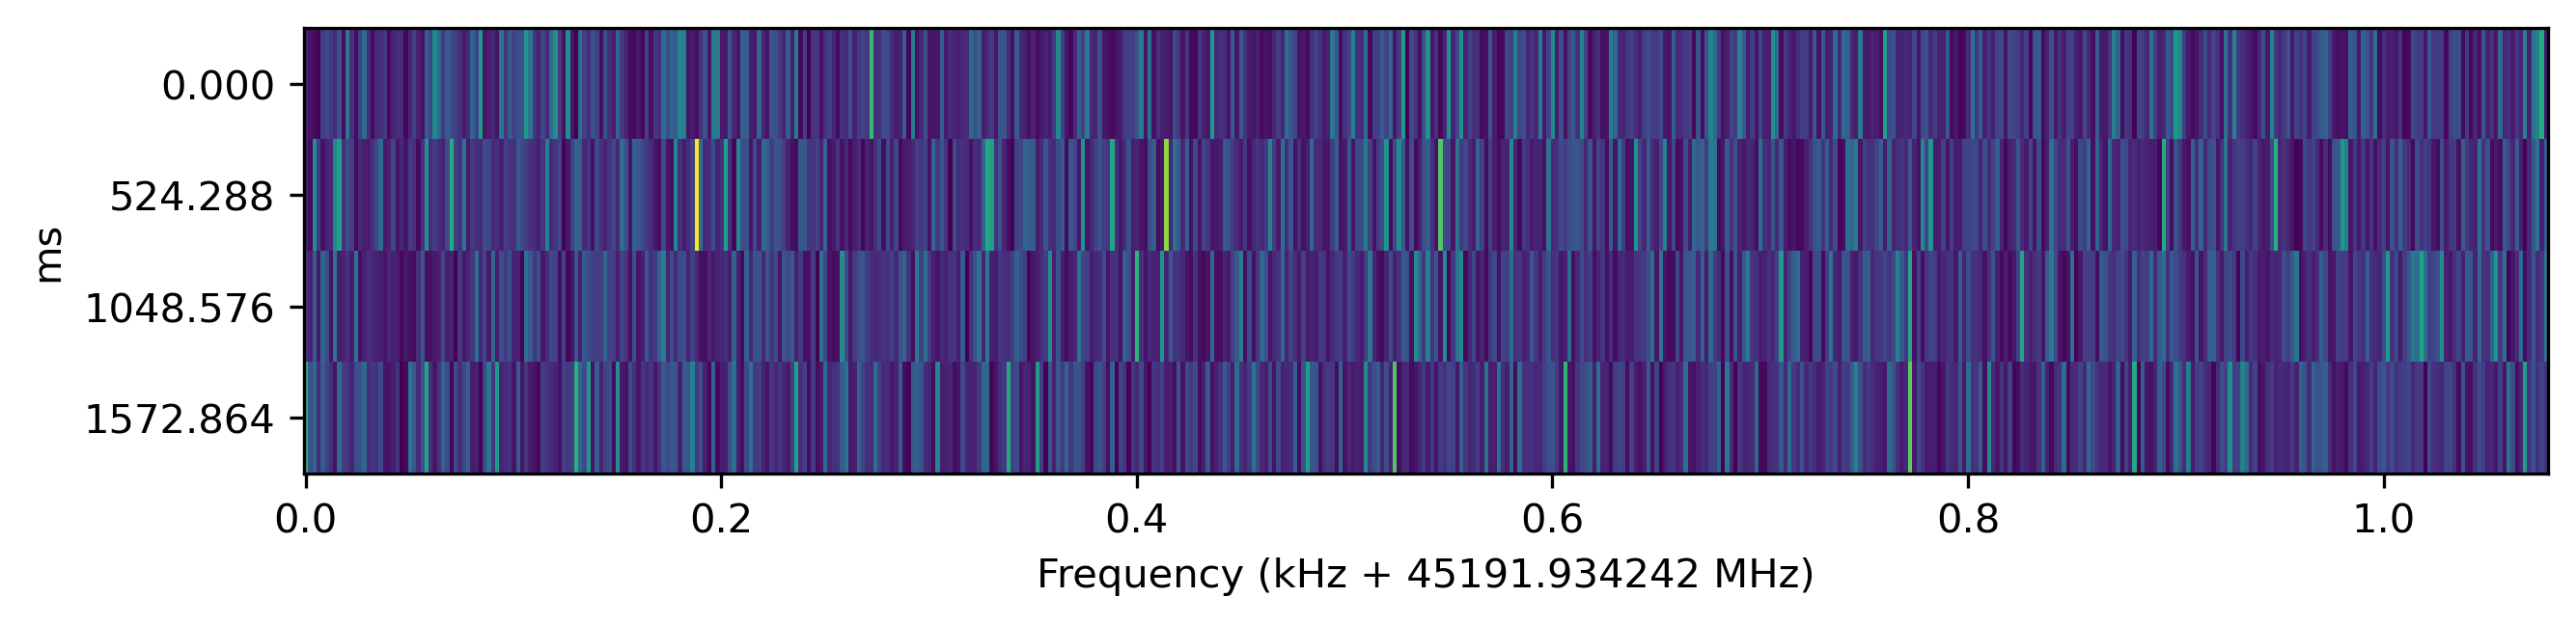

In [17]:
stamp_id = stamp_ids[0]
stamp = find_stamp_from_id(stamp_id)
print(f"f: {stamp.stamp.signal.frequency} DR: {stamp.stamp.signal.driftRate} SNR: {stamp.stamp.signal.snr}")
# stamp.show_antennas(show_signal=False)
if stamp.stamp.signal.beam >= 0:
    stamp.show_beam(0, show_signal=False)
else:
    stamp.show_classic_incoherent(show_signal=False)

# investigate_stamp(stamp)

/mnt/cosmic-storage-2/data2/vla_target/23B-169.sb44907437.eb44921666.60295.92562969908/23B-169.sb44907437.eb44921666.60295.92562969908.46.1/23B-169.sb44907437.eb44921666.60295.92562969908.46.1.AC.C384.0021.raw.seticore.0008.stamps
Index in stamp: 371
f: 45978.86789073944 DR: 35.16712846855322 SNR: 10.751001358032227
Coherent Results:
best beam is 0
original power: 3.111764e+11
original SNR: 10.751001358032227
recalculated power: 2.971129e+11
local SNR: -1.54166612081679


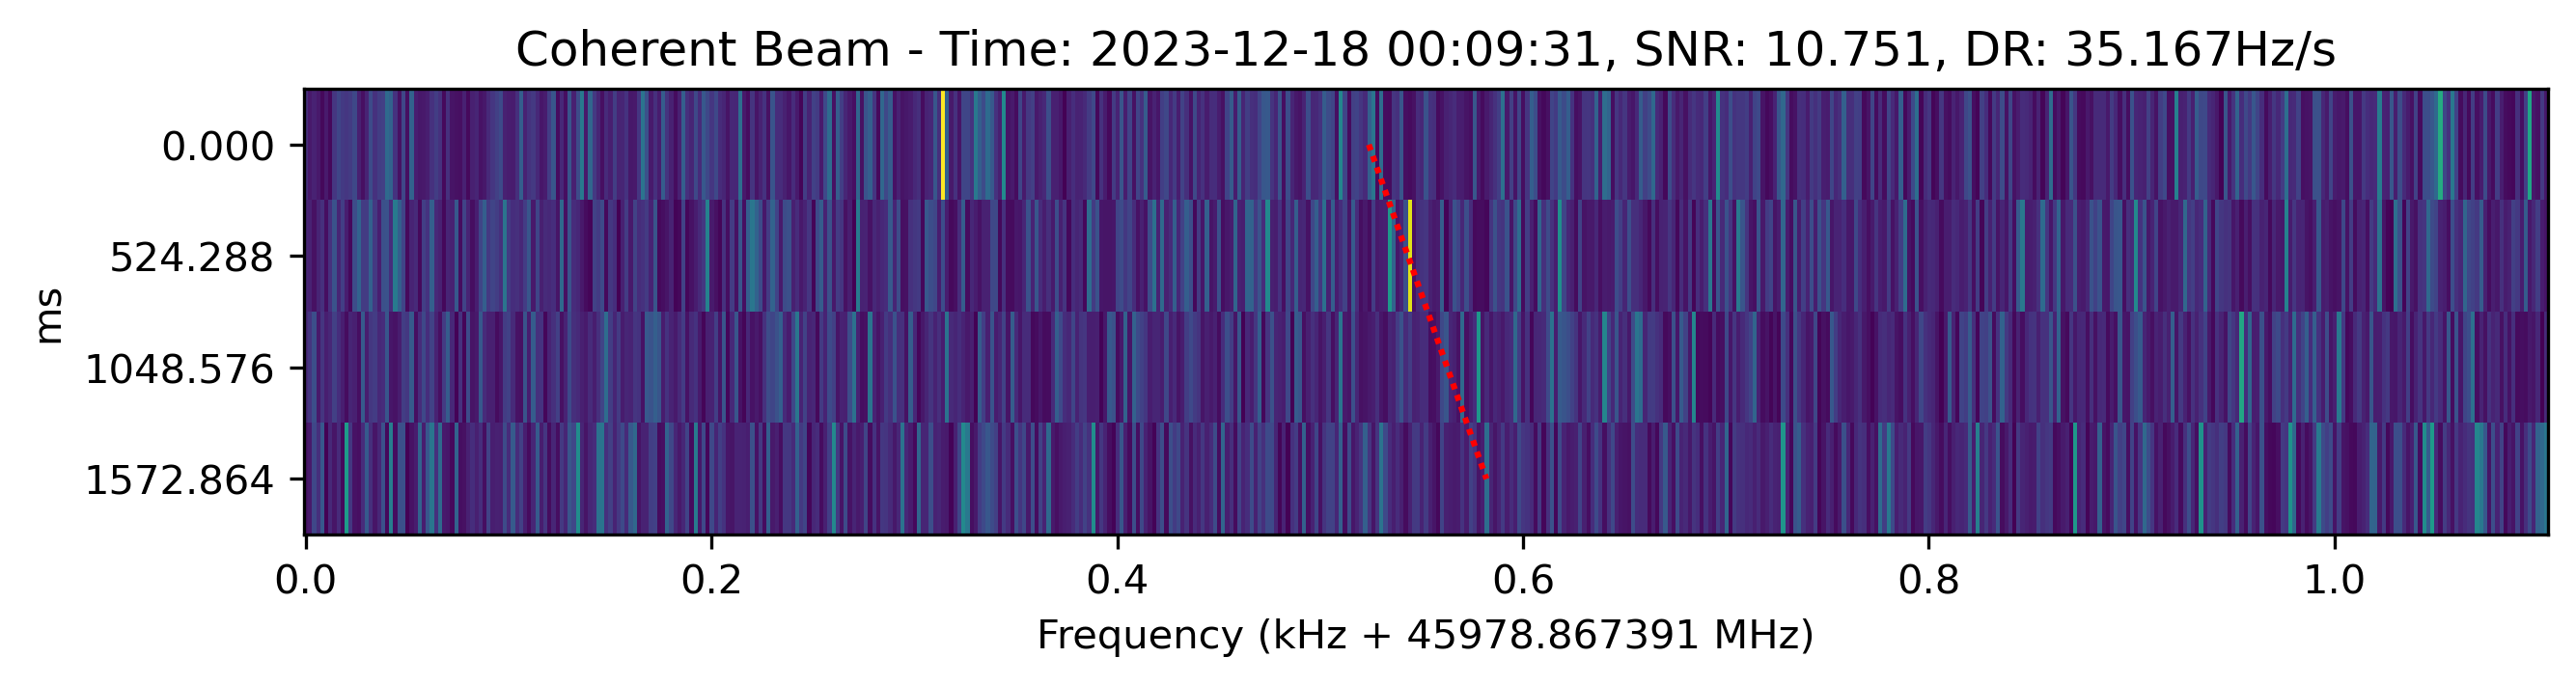

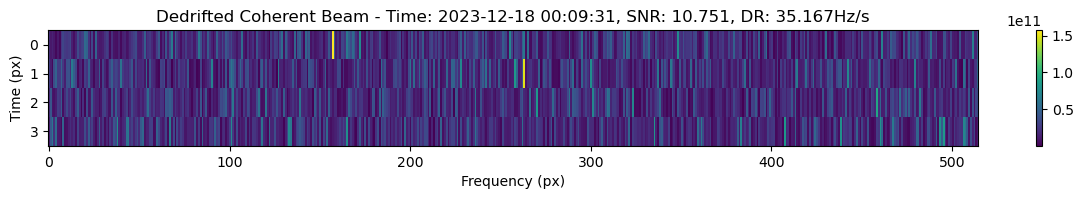

Local SNR of this stamp calculated using seticore method: 7.146206657373128


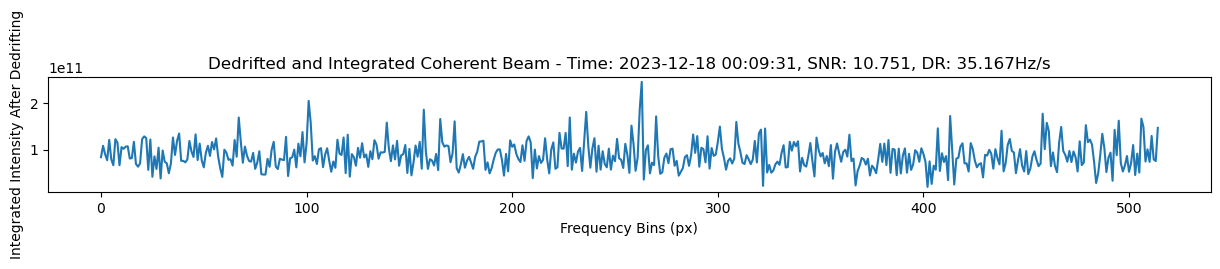

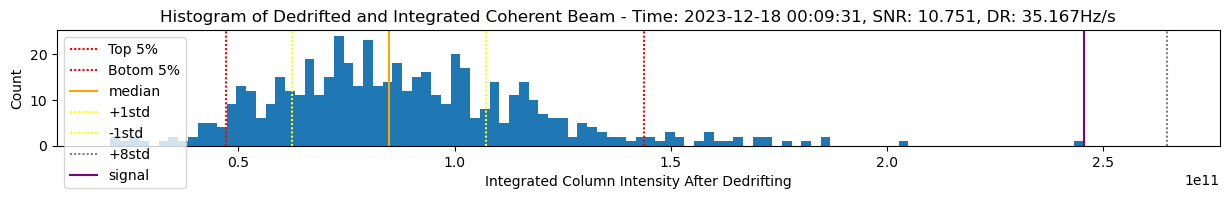

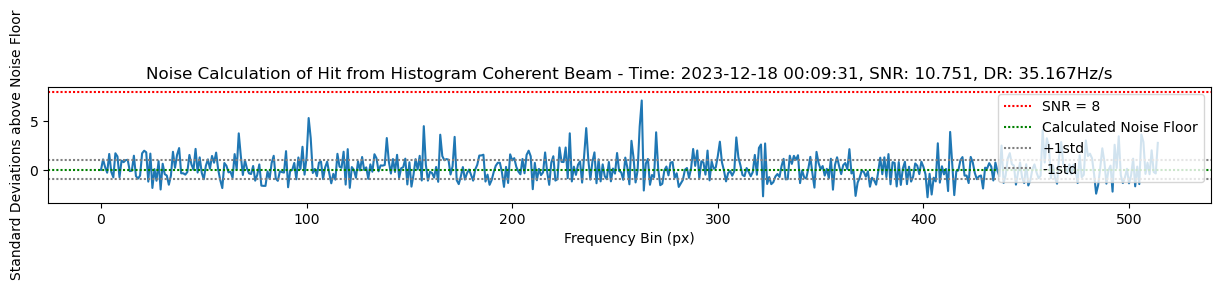

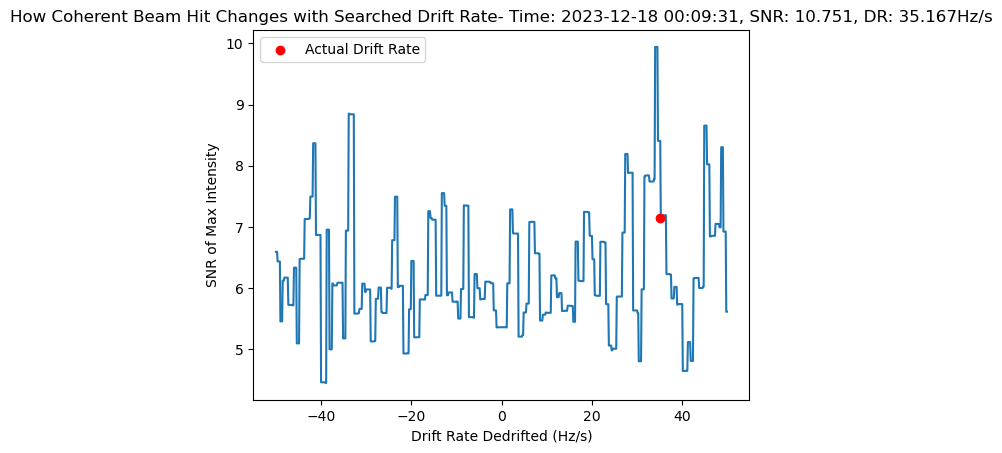

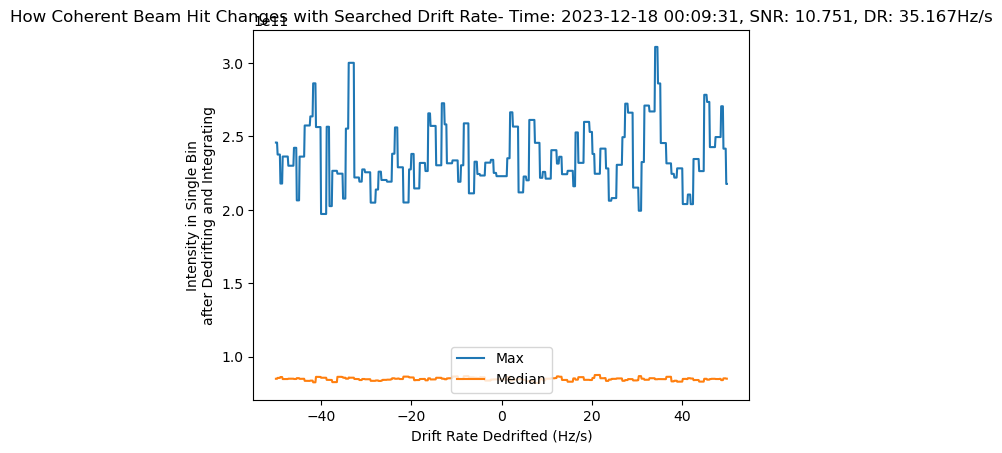

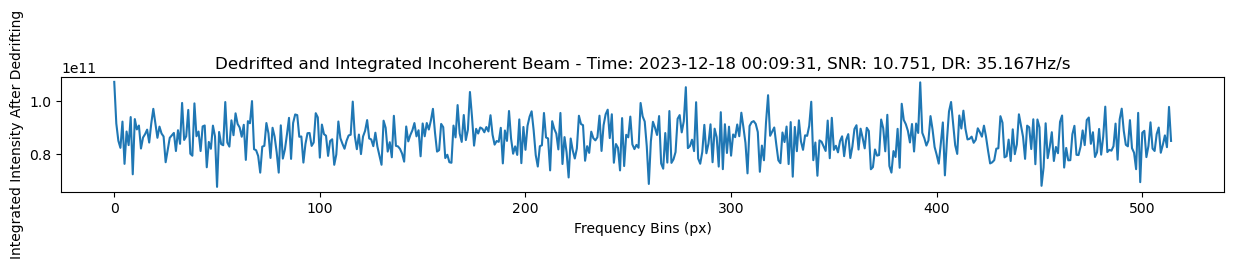

In [25]:
stamp_id = stamp_ids[1]
stamp = find_stamp_from_id(stamp_id)
print(f"f: {stamp.stamp.signal.frequency} DR: {stamp.stamp.signal.driftRate} SNR: {stamp.stamp.signal.snr}")
investigate_stamp(stamp)

/mnt/cosmic-storage-2/data2/vla_target/23B-169.sb44907437.eb44921666.60295.92562969908/23B-169.sb44907437.eb44921666.60295.92562969908.46.1/23B-169.sb44907437.eb44921666.60295.92562969908.46.1.AC.C448.0021.raw.seticore.0001.stamps
Index in stamp: 86
f: 46035.92973651886 DR: -14.551915228366852 SNR: 10.250226974487305
Coherent Results:
best beam is 0
original power: 3.027875e+11
original SNR: 10.250226974487305
recalculated power: 3.029387e+11
local SNR: -2.0683630883587183


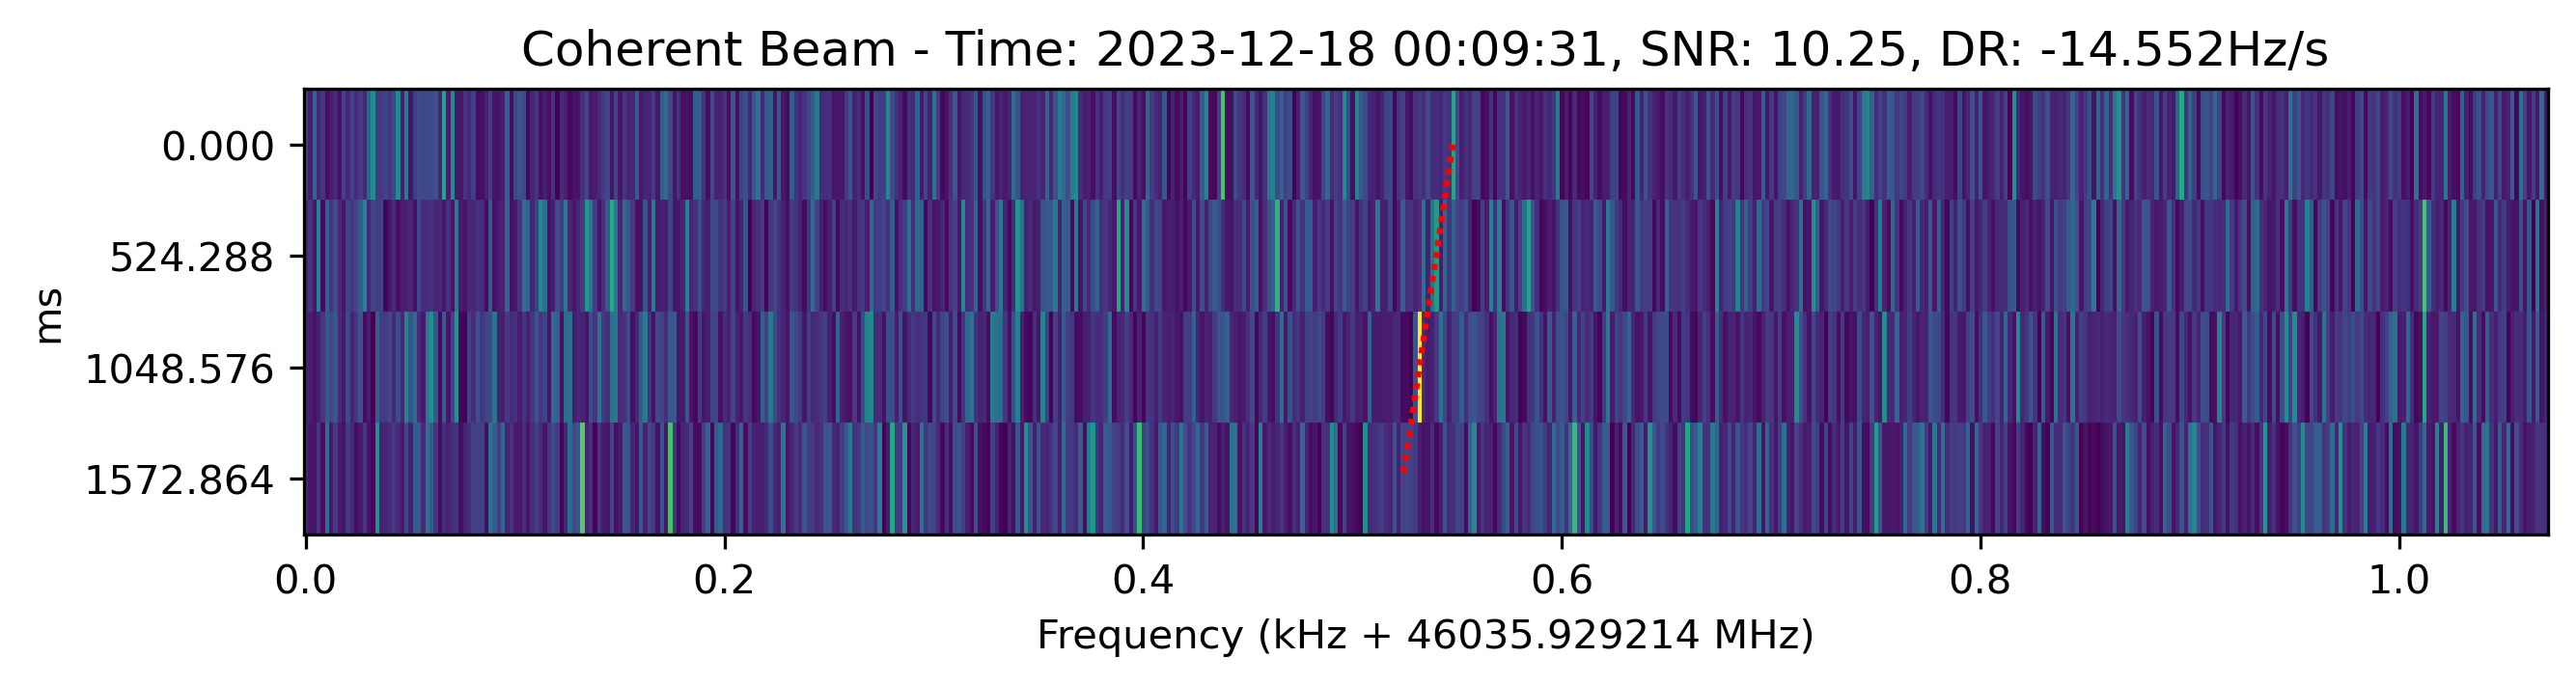

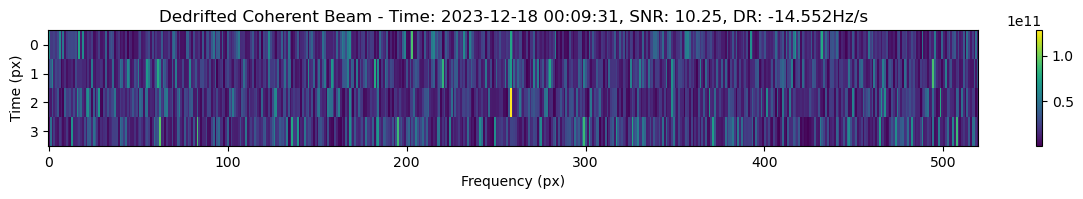

Local SNR of this stamp calculated using seticore method: 9.922183137537212


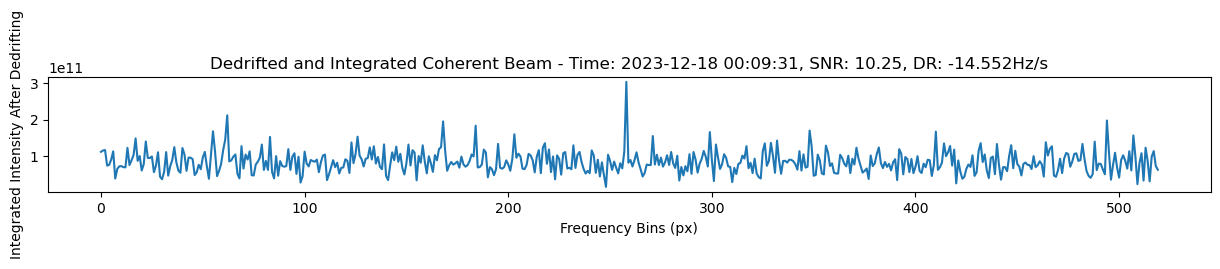

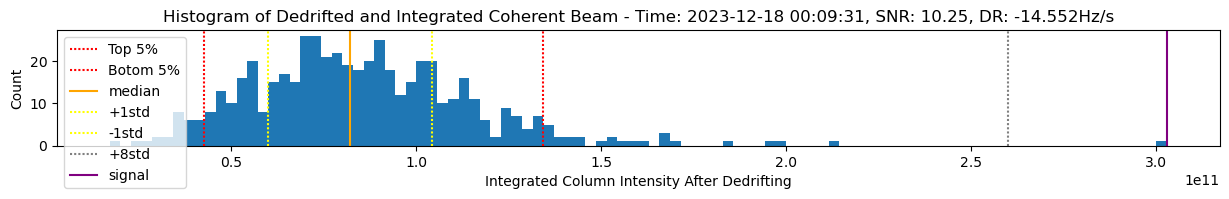

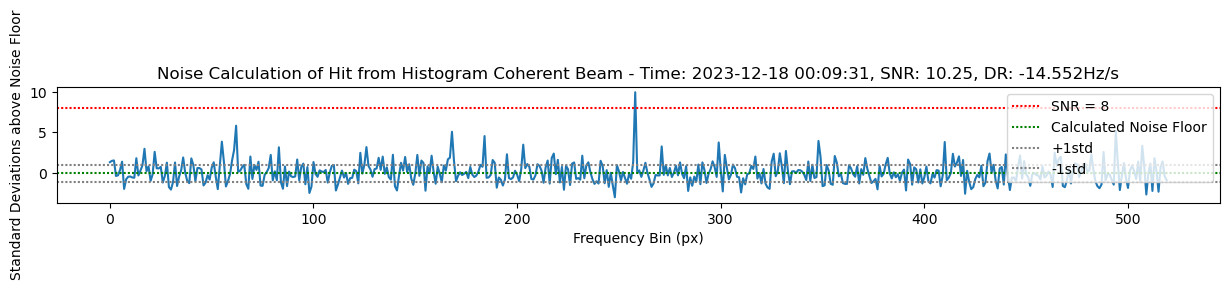

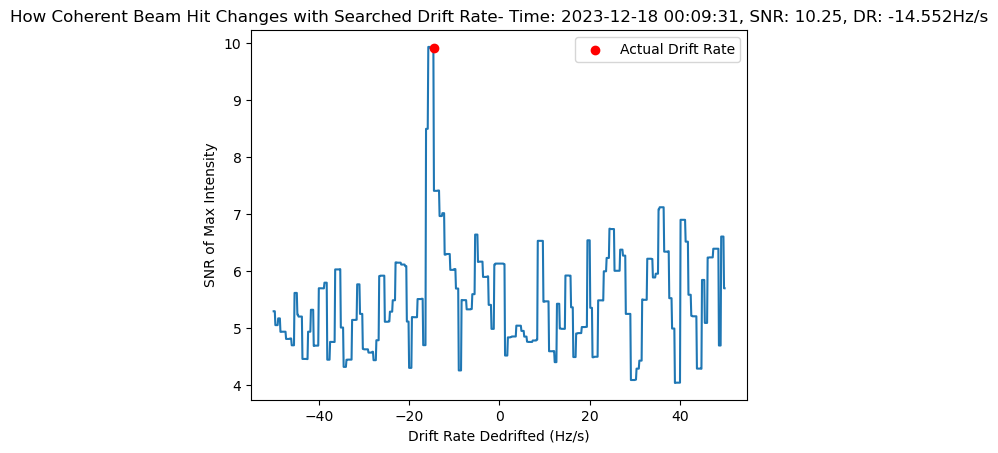

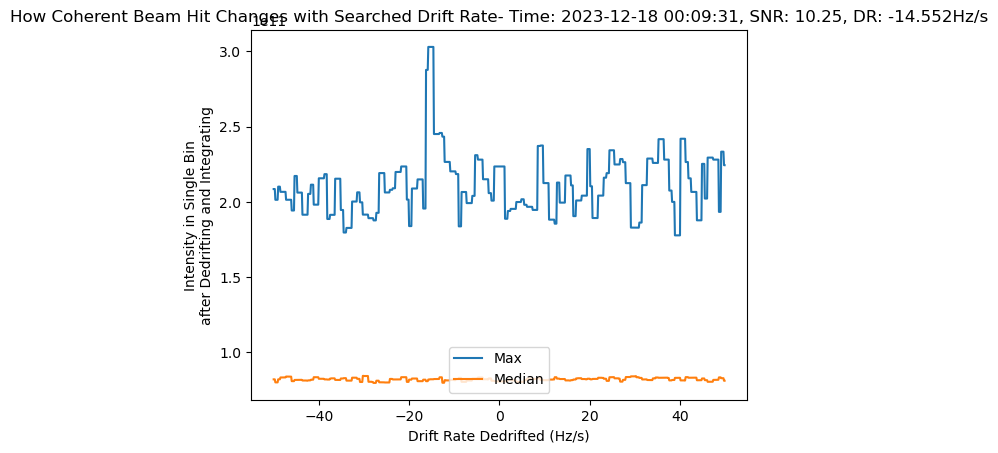

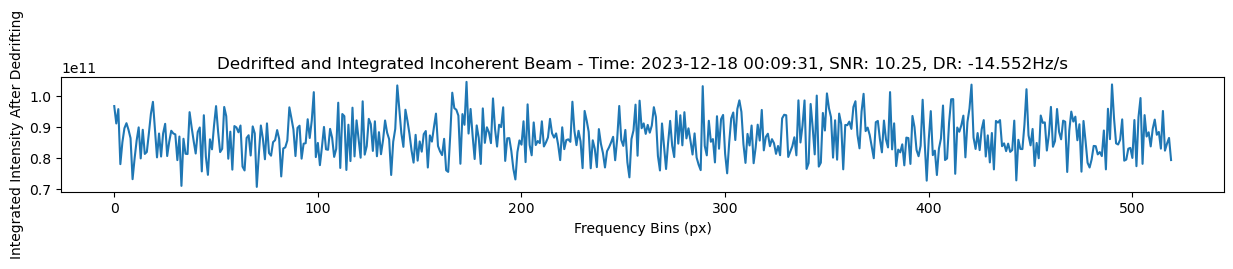

In [26]:
stamp_id = stamp_ids[2]
stamp = find_stamp_from_id(stamp_id)
print(f"f: {stamp.stamp.signal.frequency} DR: {stamp.stamp.signal.driftRate} SNR: {stamp.stamp.signal.snr}")
investigate_stamp(stamp)

/mnt/cosmic-storage-2/data2/vla_target/23B-169.sb44907437.eb44921666.60295.92562969908/23B-169.sb44907437.eb44921666.60295.92562969908.46.1/23B-169.sb44907437.eb44921666.60295.92562969908.46.1.AC.C352.0021.raw.seticore.0028.stamps
Index in stamp: 490
f: 45965.87623348236 DR: 35.16712846855322 SNR: 10.98560619354248
Coherent Results:
best beam is 0
original power: 3.185076e+11
original SNR: 10.98560619354248
recalculated power: 3.270014e+11
local SNR: -2.2056002002957156


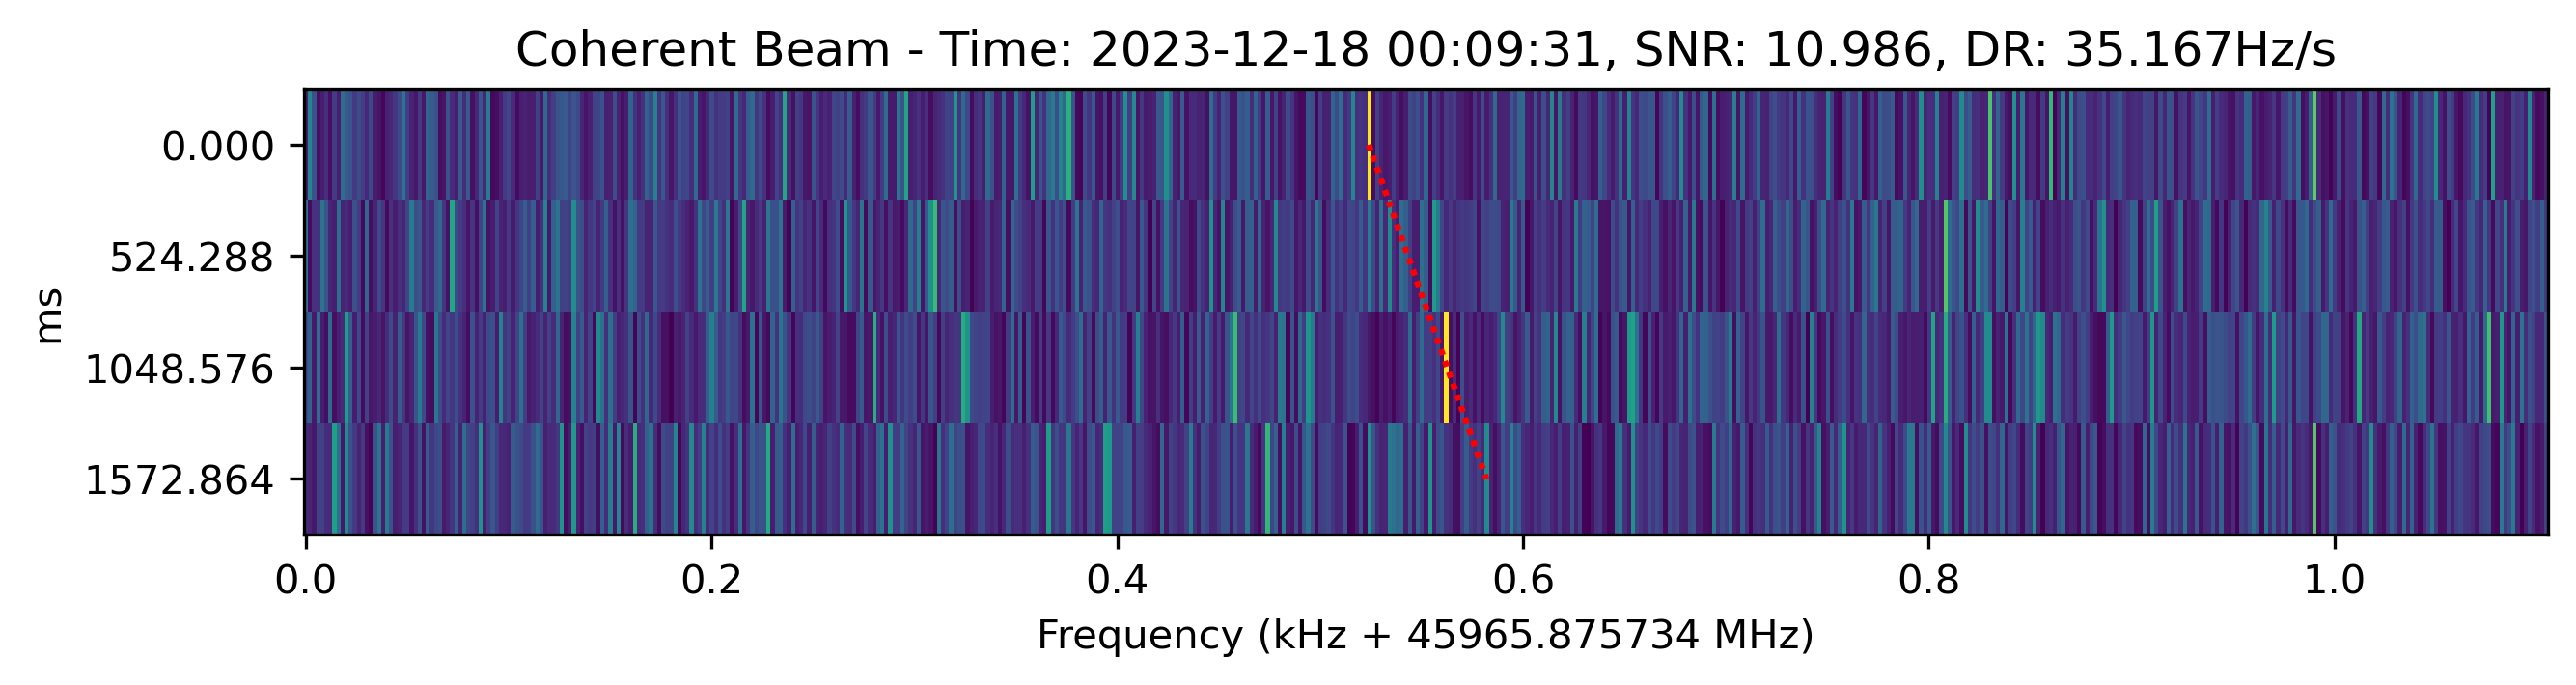

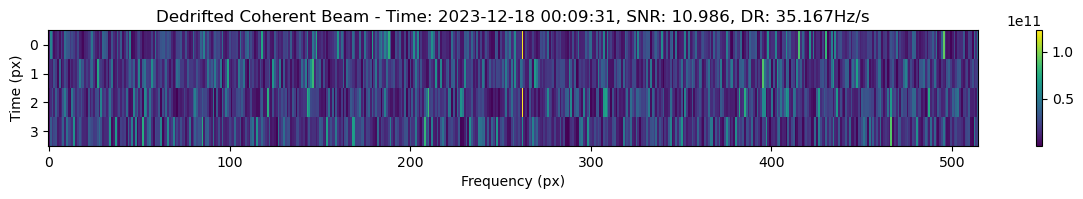

Local SNR of this stamp calculated using seticore method: 10.883025468215207


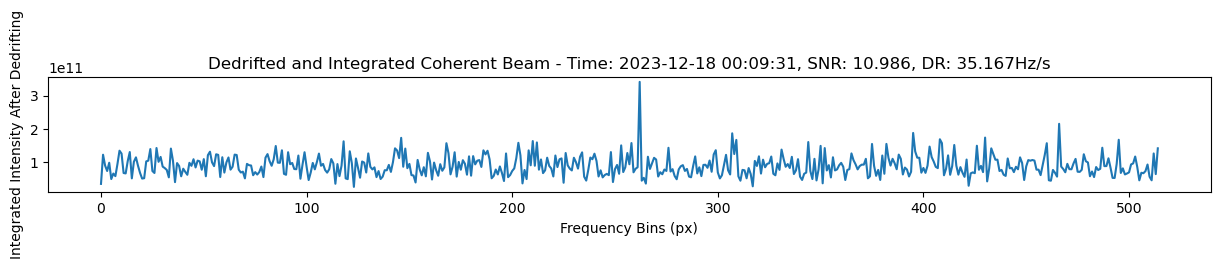

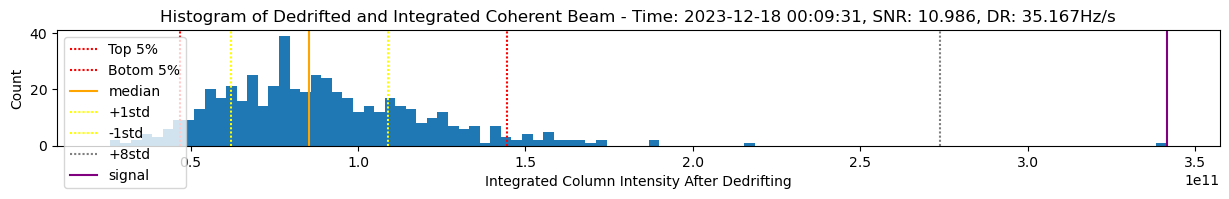

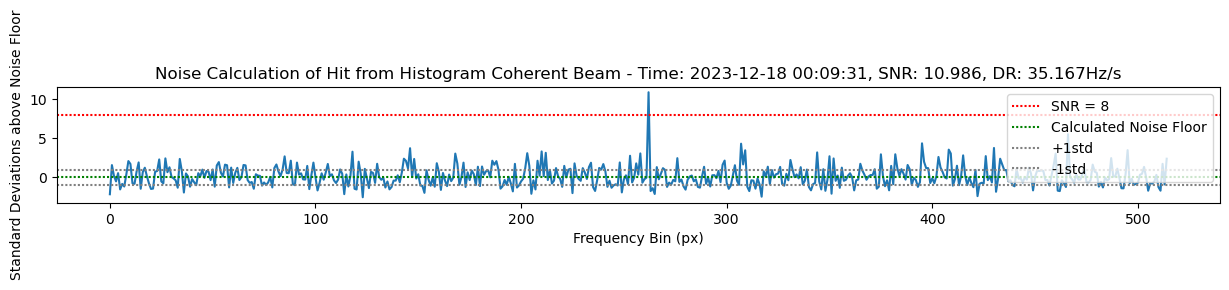

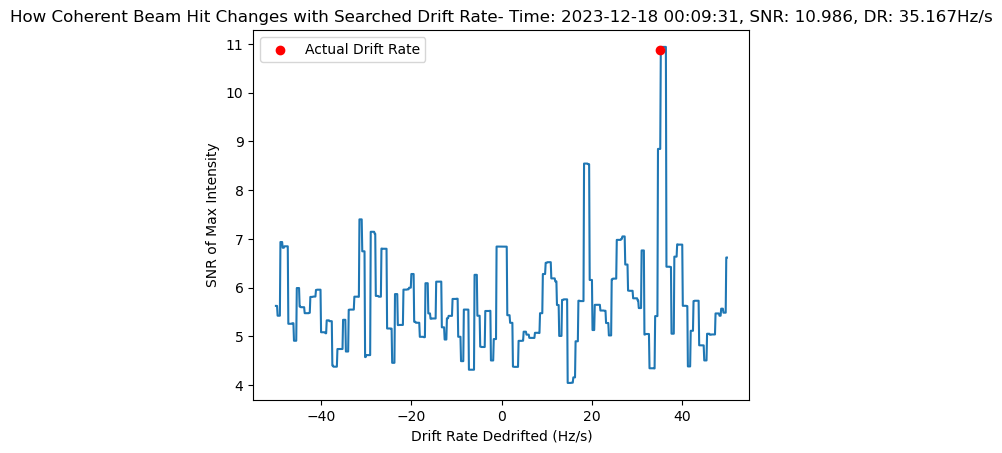

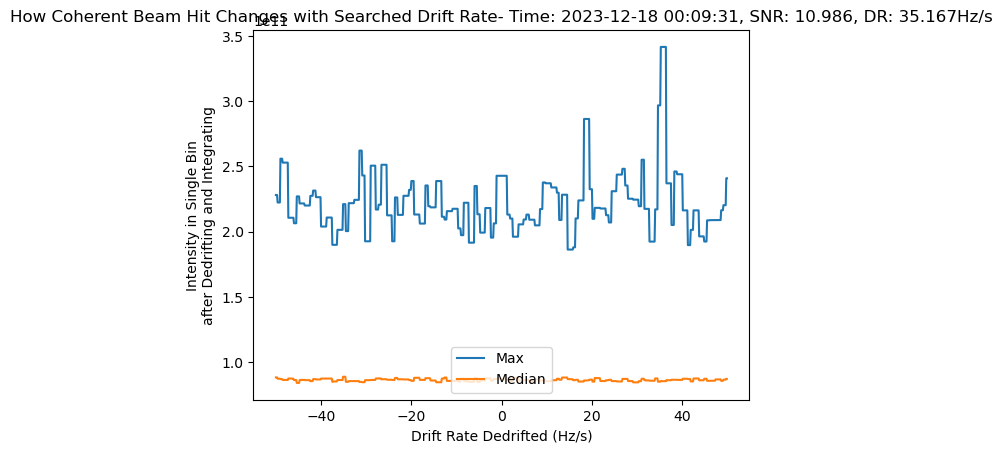

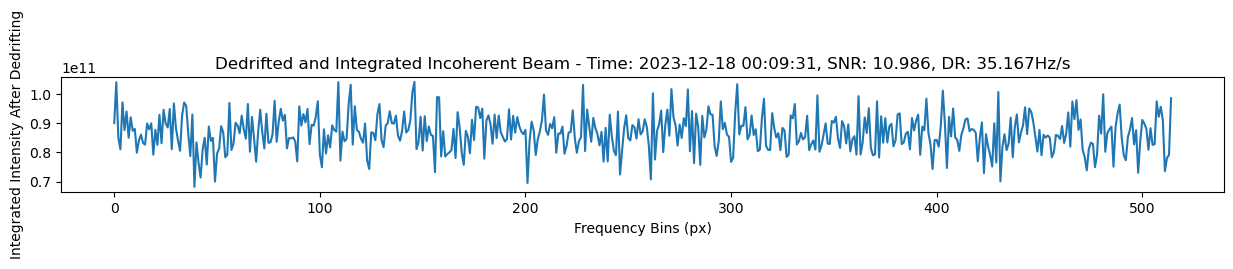

In [27]:
stamp_id = stamp_ids[3]
stamp = find_stamp_from_id(stamp_id)
print(f"f: {stamp.stamp.signal.frequency} DR: {stamp.stamp.signal.driftRate} SNR: {stamp.stamp.signal.snr}")
investigate_stamp(stamp)

/mnt/cosmic-storage-2/data2/vla_target/23B-169.sb44907437.eb44921666.60295.92562969908/23B-169.sb44907437.eb44921666.60295.92562969908.46.1/23B-169.sb44907437.eb44921666.60295.92562969908.46.1.AC.C736.0021.raw.seticore.0007.stamps
Index in stamp: 337
f: 46329.761260414125 DR: -35.16712846855322 SNR: 11.570980072021484
Coherent Results:
best beam is 0
original power: 2.585144e+11
original SNR: 11.570980072021484
recalculated power: 2.591795e+11
local SNR: -1.1553015480468367


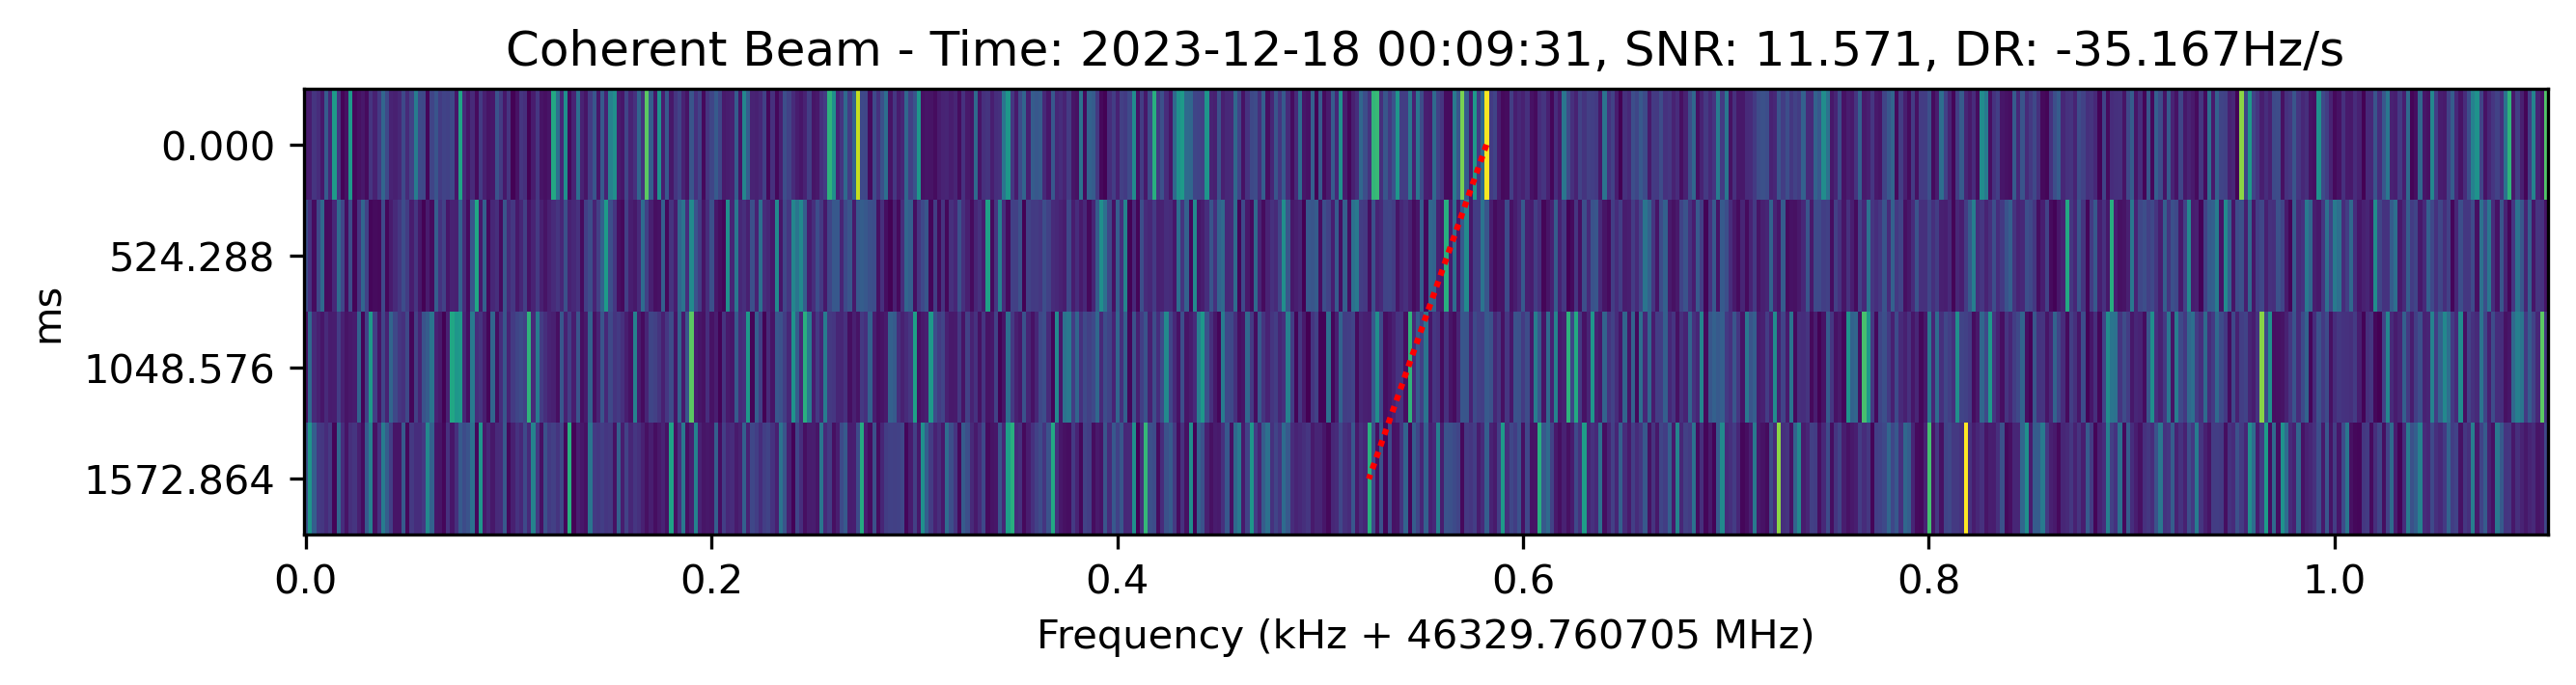

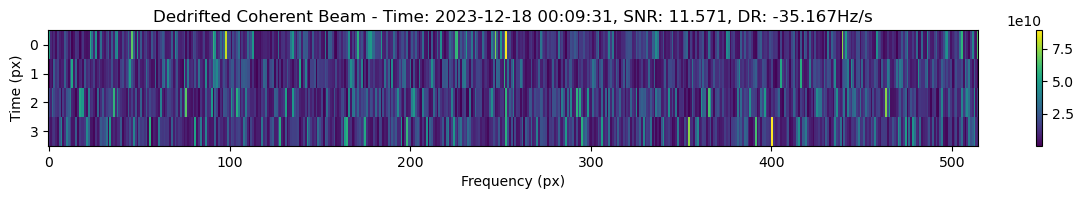

Local SNR of this stamp calculated using seticore method: 7.896839011937888


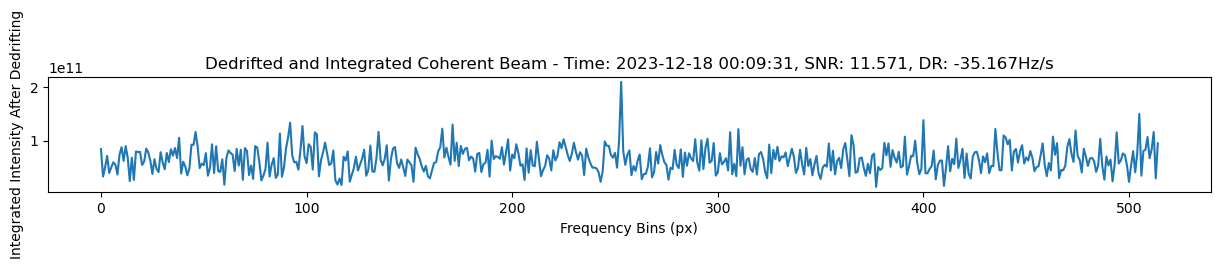

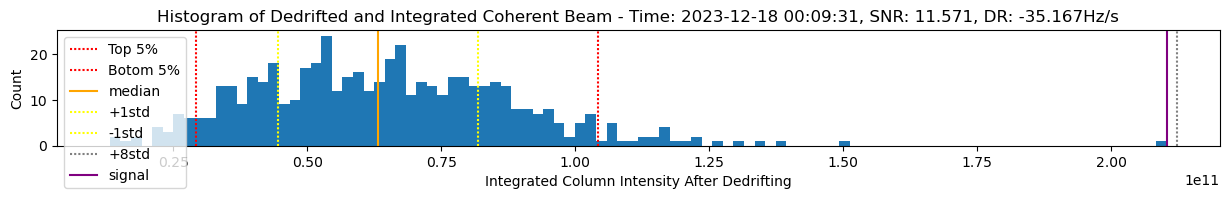

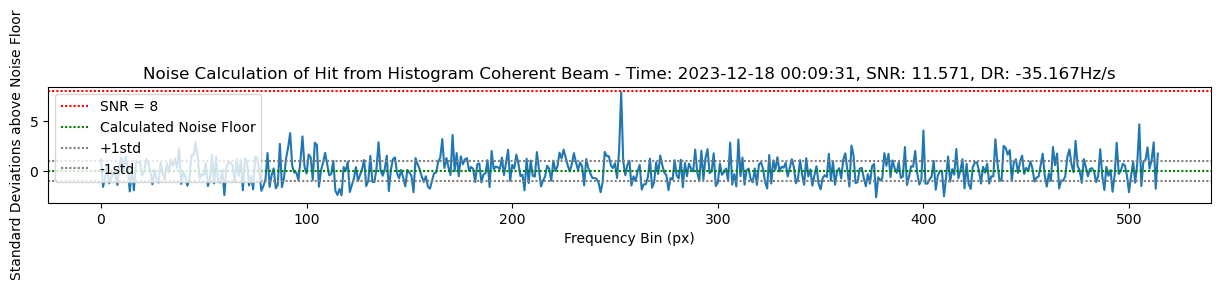

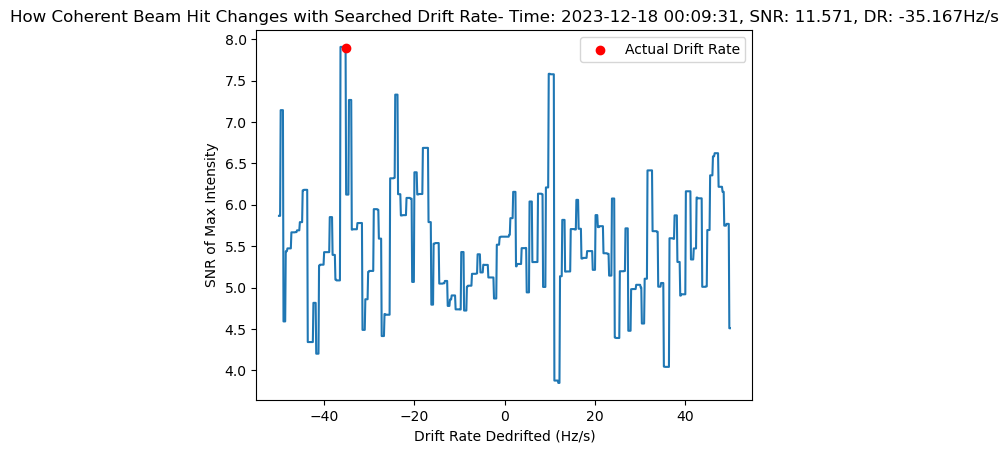

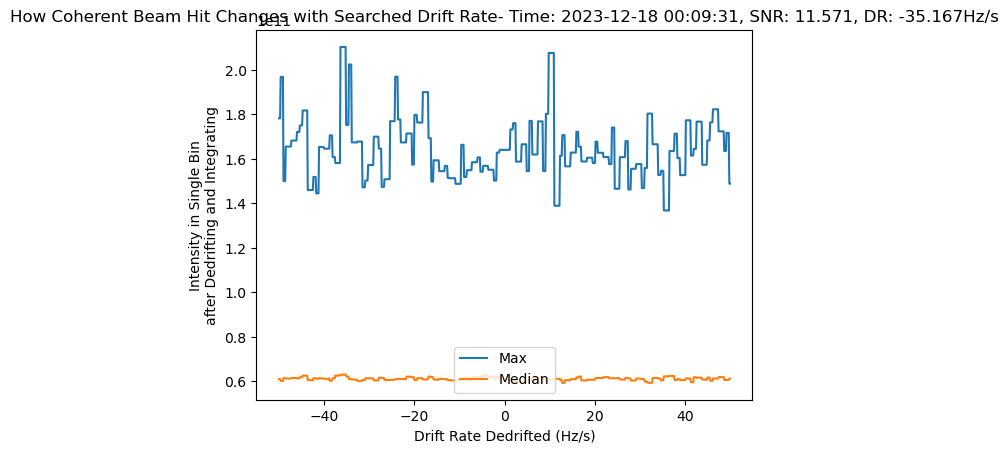

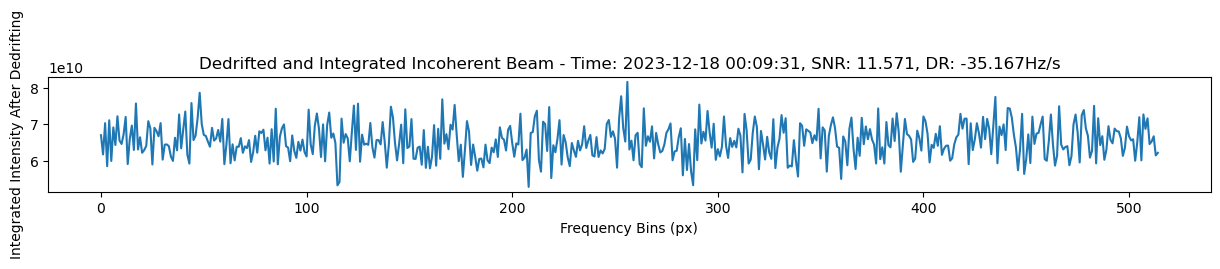

In [28]:
stamp_id = stamp_ids[4]
stamp = find_stamp_from_id(stamp_id)
print(f"f: {stamp.stamp.signal.frequency} DR: {stamp.stamp.signal.driftRate} SNR: {stamp.stamp.signal.snr}")
investigate_stamp(stamp)